In [1]:
import numpy as np
import pandas as pd
import os
import time
import keras
from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt
import imageio
import shutil

2023-04-02 19:25:50.472572: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
PIC_DIR = f'img_align_celeba/'


IMAGES_COUNT = 100

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
    pic = Image.open(PIC_DIR + pic_file).crop(crop_rect)
    pic.thumbnail((WIDTH, HEIGHT), Image.LANCZOS)
    images.append(np.uint8(pic))

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 196.68it/s]


In [3]:
images = np.array(images) / 255
print(images.shape)

(100, 128, 128, 3)


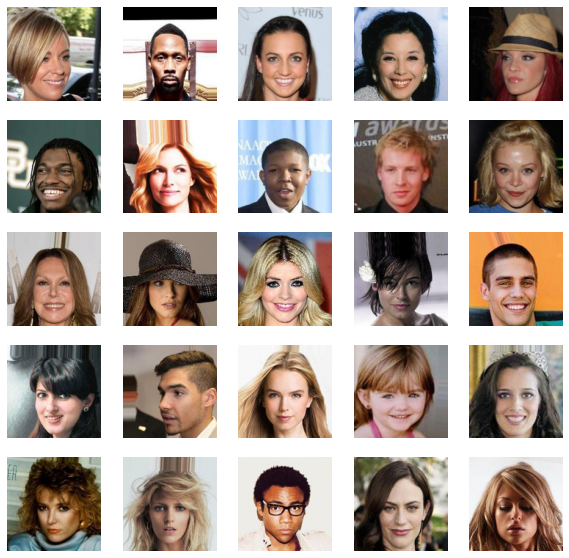

In [4]:
plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [7]:
LATENT_DIM = 32
CHANNELS = 3

def create_generator(latent_dim):
    # input layer
    generator_input = Input(shape=(latent_dim,))
    
    # project and reshape
    x = Dense(128 * 8 * 8)(generator_input)
    x = Reshape((8, 8, 128))(x)
    
    # convolutions and upsampling
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(256, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2DTranspose(512, kernel_size=4, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # final output layer
    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
    
    # model
    generator = Model(generator_input, x)
    
    return generator
generator = create_generator(latent_dim=100)
generator.summary()


2023-04-02 19:28:35.001507: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 8192)              827392    
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                   

In [8]:
def create_discriminator():
    # input layer
    discriminator_input = Input(shape=(HEIGHT, WIDTH, 3))
    
    # convolutions
    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(discriminator_input)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(256, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = Conv2D(512, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    # final output layer
    x = Flatten()(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    
    # model
    discriminator = Model(discriminator_input, x)
    
    return discriminator
discriminator = create_discriminator()
discriminator.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       819456    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 256)       0   

In [11]:
from tensorflow.keras.optimizers import RMSprop

# Define latent dimensionality of generator
LATENT_DIM = 100

# Create generator and discriminator models
generator = create_generator(LATENT_DIM)
discriminator = create_discriminator()

# Set up GAN
gan_input = Input(shape=(LATENT_DIM,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

# Compile GAN
optimizer = RMSprop(lr=0.0001, clipvalue=1.0, decay=1e-8)
gan.compile(loss='binary_crossentropy', optimizer=optimizer)


/Users/macbookair/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
def train(generator, discriminator, gan, images, epochs, batch_size, sample_interval):
    # Rescale images to -1 to 1
    images = (images - 0.5) * 2.0

    # Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train discriminator
        idx = np.random.randint(0, images.shape[0], batch_size)
        real_imgs = images[idx]
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        gen_imgs = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        noise = np.random.normal(0, 1, (batch_size, LATENT_DIM))
        g_loss = gan.train_on_batch(noise, valid)

        # Print progress
        print(f"Epoch {epoch+1}/{epochs} - Discriminator loss: {d_loss:.4f} - Generator loss: {g_loss:.4f}")

        # Save generated images at sample interval
        if (epoch+1) % sample_interval == 0:
            save_images(generator, epoch+1)

In [14]:
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y


In [18]:
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = generator.predict(x_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X, y


In [19]:
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input


1/1 [==============================] - 15s 15s/step


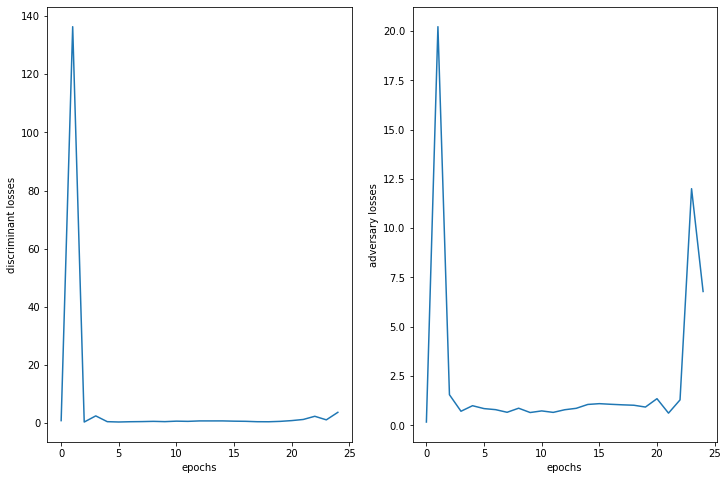

In [20]:
epochs = 5
iters = 5*epochs
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2

# create generator and discriminator models
generator = create_generator(LATENT_DIM)
discriminator = create_discriminator()

# compile discriminator
discriminator.compile(optimizer=RMSprop(lr=0.0008), loss='binary_crossentropy')

# create GAN model
gan_input = Input(shape=(LATENT_DIM,))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

# compile GAN
gan_optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

# train the GAN
d_losses = []
a_losses = []
for i in range(iters):
    # train discriminator on real images
    X_real, y_real = get_real_samples(images, batch_size)
    d_loss_real = discriminator.train_on_batch(X_real, y_real)

    # train discriminator on generated images
    X_fake, y_fake = generate_fake_samples(generator, LATENT_DIM, batch_size)
    d_loss_fake = discriminator.train_on_batch(X_fake, y_fake)

    # calculate total discriminator loss
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # train GAN
    X_gan = np.random.normal(size=(batch_size, LATENT_DIM))
    y_gan = np.ones((batch_size, 1))
    a_loss = gan.train_on_batch(X_gan, y_gan)

    # append losses for plotting
    d_losses.append(d_loss)
    a_losses.append(a_loss)

    # generate and save images every 1000 iterations
    if (i+1) % 1000 == 0:
        save_generated_images(generator, control_vectors, RES_DIR, FILE_PATH % ('iter', i+1))

# plot losses
plt.figure(1, figsize=(12, 8))
plt.subplot(121)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(122)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()

In [29]:
train(discriminator = 10, gan = 5, images = 100, epochs = 5, batch_size = 16, sample_interval=10, generator = 10)

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('v.gif', images_to_gif)
shutil.rmtree(RES_DIR)


AttributeError: 'float' object has no attribute 'shape'